In [7]:
#|default_exp resnet

In [8]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *

In [9]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [10]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

In [11]:
#|export
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)

In [12]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)


In [13]:
def get_model(act=nn.ReLU, nfs=(8,16,32,64,128), norm=nn.BatchNorm2d):
    layers = [conv(1, 8, stride=1, act=act, norm=norm)]
    layers += [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None, norm=norm, bias=True), nn.Flatten()).to(def_device)

In [14]:
set_seed(42)
lr,epochs = 6e-2,5
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)


In [15]:
# learn.fit(epochs)

Training deeper (more layers) than we are setup now can be quite challenging.

One way to resolve this is with a residual network (resnet) Resnets work by having a block (multiple conv layers) that are skipped. The activation method of the block is passed both the outputs from the residual block plus the input (modified to fit the shape of the output)

This method was introduced in a paper [here](https://arxiv.org/abs/1512.03385)

In [16]:
#|export
def conv_block(n_inputs, n_filters, stride, act=act_gr, norm=None, kernal_size=3):
    return nn.Sequential(conv(n_inputs, n_filters, stride=1, act=act, norm=norm, ks=kernal_size), # Filter change happens here
                         conv(n_filters, n_filters, stride=stride, act=None, norm=norm, ks=kernal_size)) # Stride occurs here, No activation here, that happens after the identity is added.
                        
class ResBlock(nn.Module):
    def __init__(self, n_inputs, n_filters, stride=1, kernal_size=3, act=act_gr, norm=None):
        super().__init__()
        self.convs = conv_block(n_inputs, n_filters, stride, act=act_gr, norm=norm, kernal_size=kernal_size)
        self.idconv = fc.noop if n_inputs==n_filters else conv(n_inputs, n_filters, ks=1, stride=1, act=None) # makes filter change to identity block
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True) # handles the stride for the identity block
        self.act = act()
    
    def forward(self, x): return self.act(self.convs(x) + self.idconv(self.pool(x)))



In [17]:
# This model now has two additional steps channel sizes, 
# the first layer has a stride of one, so there is no shrinking of the input sizes
# Now we can use the last layer to step the channels up to 256
# In each step here we are also using a resblock giving us two convs per step where we used to use just one
def get_model(act=nn.ReLU, nfs=(8,16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 8, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)


In [18]:
@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num params|\n|--|--|--|--|\n'
    tot = 0
    def _f(hook, mod, inp, outp):
        nonlocal res,tot
        nparms = sum(o.numel() for o in mod.parameters())
        tot += nparms
        res += f'|{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{nparms}|\n'
    with Hooks(self.model, _f) as hooks: self.fit(1, lr=1, train=False, cbs=SingleBatchCB())
    print("Tot params: ", tot)
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else: print(res)


In [19]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).summary()

Tot params:  1228908


|Module|Input|Output|Num params|
|--|--|--|--|
|ResBlock|(2048, 1, 28, 28)|(2048, 8, 28, 28)|712|
|ResBlock|(2048, 8, 28, 28)|(2048, 16, 14, 14)|3696|
|ResBlock|(2048, 16, 14, 14)|(2048, 32, 7, 7)|14560|
|ResBlock|(2048, 32, 7, 7)|(2048, 64, 4, 4)|57792|
|ResBlock|(2048, 64, 4, 4)|(2048, 128, 2, 2)|230272|
|ResBlock|(2048, 128, 2, 2)|(2048, 256, 1, 1)|919296|
|Flatten|(2048, 256, 1, 1)|(2048, 256)|0|
|Linear|(2048, 256)|(2048, 10)|2560|
|BatchNorm1d|(2048, 10)|(2048, 10)|20|


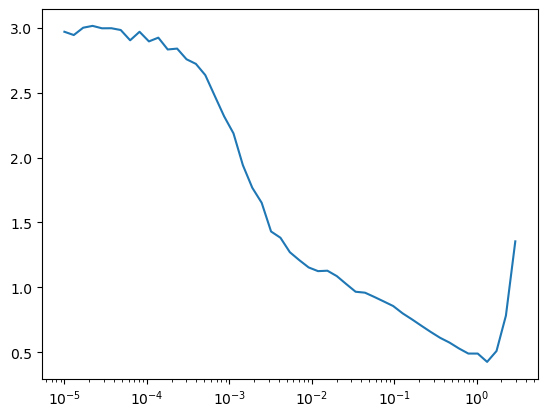

In [20]:
MomentumLearner(get_model(act_gr, norm=nn.BatchNorm2d).apply(iw), dls, F.cross_entropy, cbs=DeviceCB()).lr_find()

In [21]:
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)


accuracy,loss,epoch,train
0.812,0.713,0,train
0.826,0.564,0,eval


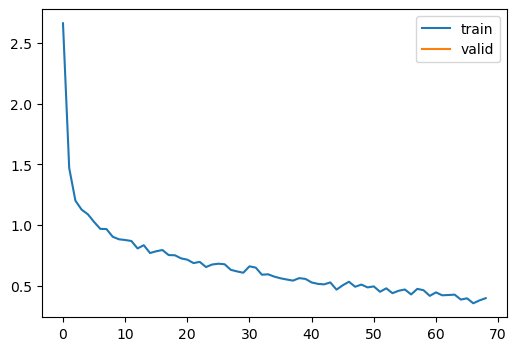

KeyboardInterrupt: 

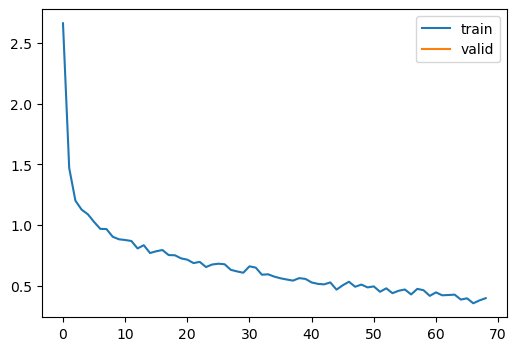

In [22]:
learn.fit(epochs)

According to Jeremy howard this model beat any of the timm models

In [ ]:
import nbdev; nbdev.nbdev_export()